# Projet de Python pour la data science 2024 : Prédiction de la demande de recharge de véhicules électriques à Paris
#### Encadrant : M. Victor Quétu 
#### Étudiants : Avner EL BAZ, Manuel Junior NDEFFO NKAMGUE, Daniel TRUSKINOVSKY

![borne-elect](/home/onyxia/work/images/borne-elect.jpg)

Dans une perspective éco-responsable d'adaptation des déplacements quotidiens, l'usage de la voiture électrique a le vent en poupe en France. En 2023, 17% des voitures achetées neuves étaient tout électriques et 9% étaient hybrides. En Île-de-France, les ventes de véhicules tout électriques ont augmenté de 60% entre 2022 et 2023, et celles de véhicules hybrides de 41%. 

Ainsi, la ville de Paris s'est dotée d'un réseau de bornes de recharge de véhicules, initialement créées pour les véhicules en libre-service Autolib' de 2011 jusqu'à l'arrêt du service en 2018. En 2021, le service Belib' est créé pour opérer le réseau de bornes et augmenter l'offre dans la capitale.

Nous étudions dans ce projet un jeu de données tiré de plusieurs API publiques de la ville de Paris, obtenu sur la plateforme Challenge Data, gérée par le data lab de l'ENS Paris. Ce jeu de données contient les informations de disponibilité des stations de recharge électrique à Paris du 25/11/2019 au 8/11/2020 et des données sur les bornes sans évolution temporelle. Nous y incorporons également des données de trafic routier pour l'année 2020, que nous avons importé des API de la ville de Paris également.

Avec l'augmentation du nombre de véhicules électriques, de nombreuses nouvelles stations ont été implantées à Paris : il est intéressant de voir si l'on pouvait, a priori, prédire les emplacements où de nouvelles stations devait être implantées et si cela a effectivement été le cas. Les API de Paris OpenData étant toujours actives, on pourra comparer aux données actuelles.

#### Importation des librairies

In [ ]:
import numpy as np
import pandas as pd
import folium
import seaborn as sns
import matplotlib.pyplot as plt


#### Description des données

1) Belib' - Prises de recharge pour véhicules électriques - Disponibilité temps réel

Ce jeu de données recense le statut de chaque borne de recharge à Paris : Disponible, En Charge, Passive (branchée mais ne délivrant pas de courant), Hors ligne (ne transmettant pas d'information sur son statut, parmi les 3 précédents), Hors d'usage (en travaux). Les données sont actualisées toutes les 15 minutes sur la période concernée.

2) Belib' - Prises de recharge pour véhicules électriques - Données statiques

Ce jeu de données contient des informations sur les bornes de recharge : localisation géographique, adresse, identifiant sous la forme Sk-Tj pour la borne j de la station k, dispositifs de recharge disponibles.

3) Meteociel - Prévision météo en temps réel

Les données de ce 3ème dataset étant peu interprétables, nous les avons laissé de côté dans cette étude.

Nous avons à la place importé l'historique des données de comptage routier sur l'année 2020 à Paris (API : Comptage routier - Données trafic issues des capteurs permanents). Ce jeu de données contient la mesure du débit de véhicules et du niveau de congestion sur plusieurs "arcs" de comptage routier, évalués toutes les heures du 1er janvier au 31 décembre 2020. Un "arc" désigne un tronçon de rue ou d'avenue où les variables de trafic sont mesurées entre un "noeud amont" et un "noeud aval"




#### Importation des données

In [5]:
df_real_time=pd.read_csv("ytrain_NpxebDC.csv")
df_static=pd.read_csv("info_static.csv")

/tmp/ipykernel_89854/656849402.py:1: DtypeWarning: Columns (1,3,5,11,20,49,52,54,55,56,64,70,71,94,95,101,102,114,129,131,132,133,138,139,152,157,163,174,180,184,193,196,201,207,208,219,220,228,241,245,250,256,258,264,265,269,270,271,272,273) have mixed types. Specify dtype option on import or set low_memory=False.
  df_real_time=pd.read_csv("ytrain_NpxebDC.csv")


In [50]:
df_real_time.head()


,timestamp,S7-T1,S2-T1,S19-T1,S56-T3,S85-T3,S16-T3,S16-T1,S94-T3,S28-T1,...,S47-T2,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2
0,2019-11-25 00:00:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
1,2019-11-25 00:15:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
2,2019-11-25 00:30:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
3,2019-11-25 00:45:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN
4,2019-11-25 01:00:00+00:00,Down,Down,Available,Down,Down,Offline,Offline,Offline,Available,...,Down,Offline,Offline,Available,Available,NaN,NaN,NaN,NaN,NaN


In [51]:
df_static.head()

,t_id,s_id,latitude,longitude,street,city,zipcode,model
0,S84-T1,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"E/F, Combo, T2, CHAdeMO, T3"
1,S84-T3,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"CHAdeMO, T2, T3, E/F, Combo"
2,S86-T1,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"CHAdeMO, Combo, T2, T3, E/F"
3,S86-T2,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,E/F
4,S86-T3,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"T3, Combo, CHAdeMO, E/F, T2"


#### Traitement des données

L'année 2020 introduit un biais évident pour l'étude de la disponibilité des stations : la pandémie de COVID-19.

Les cartes thermiques réalisées ci-dessous montrent une baisse significative de l'usage des bornes pendant le premier confinement du 16 mars au 11 mai 2020. Nous avons donc décidé de centrer notre étude sur la période du **1er janvier au 15 mars 2020** (on ignore les valeurs de fin 2019 car les données de trafic commencent en 2020).

/tmp/ipykernel_131208/866894008.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  status_data = df_real_time.replace({'Down': 1, 'Offline': 0, 'Available': -1, 'Charging': 2, 'Passive': 3})


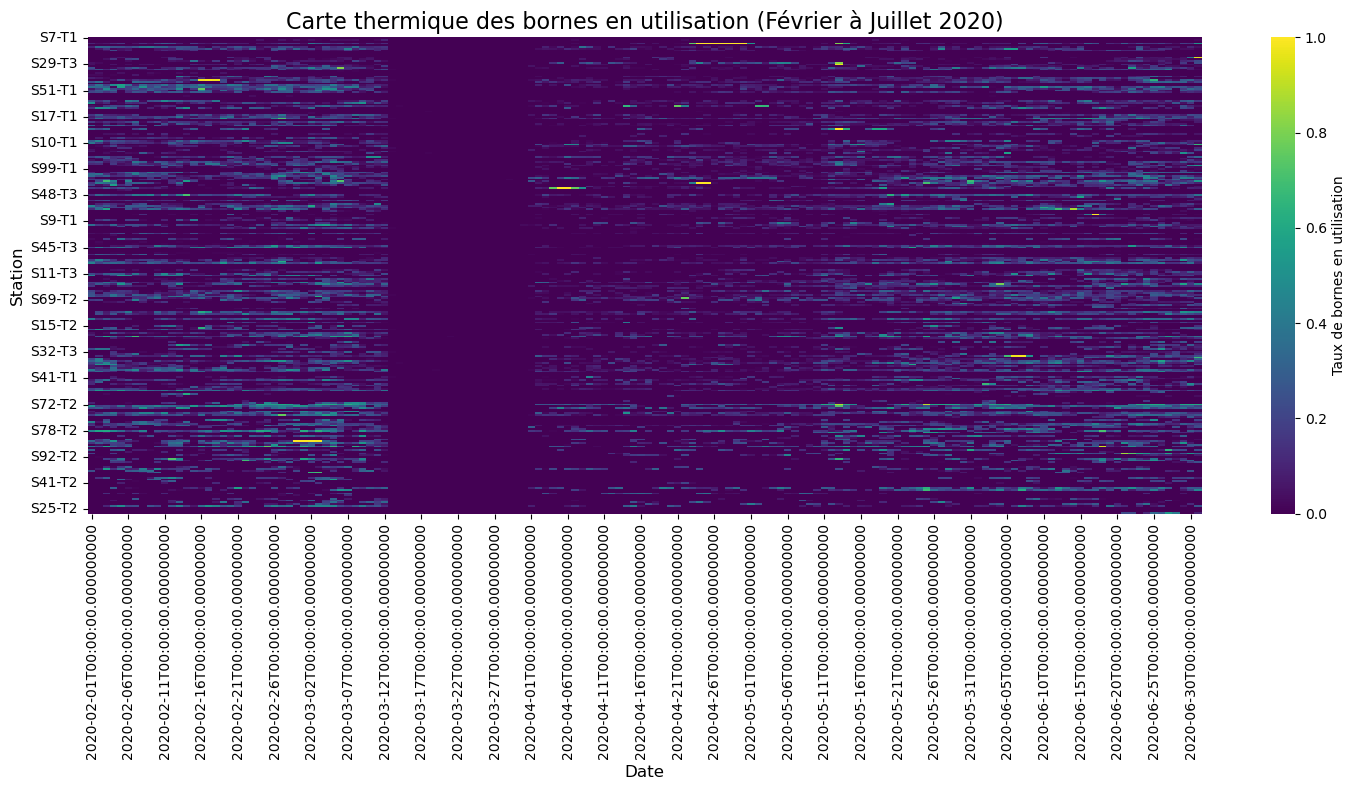

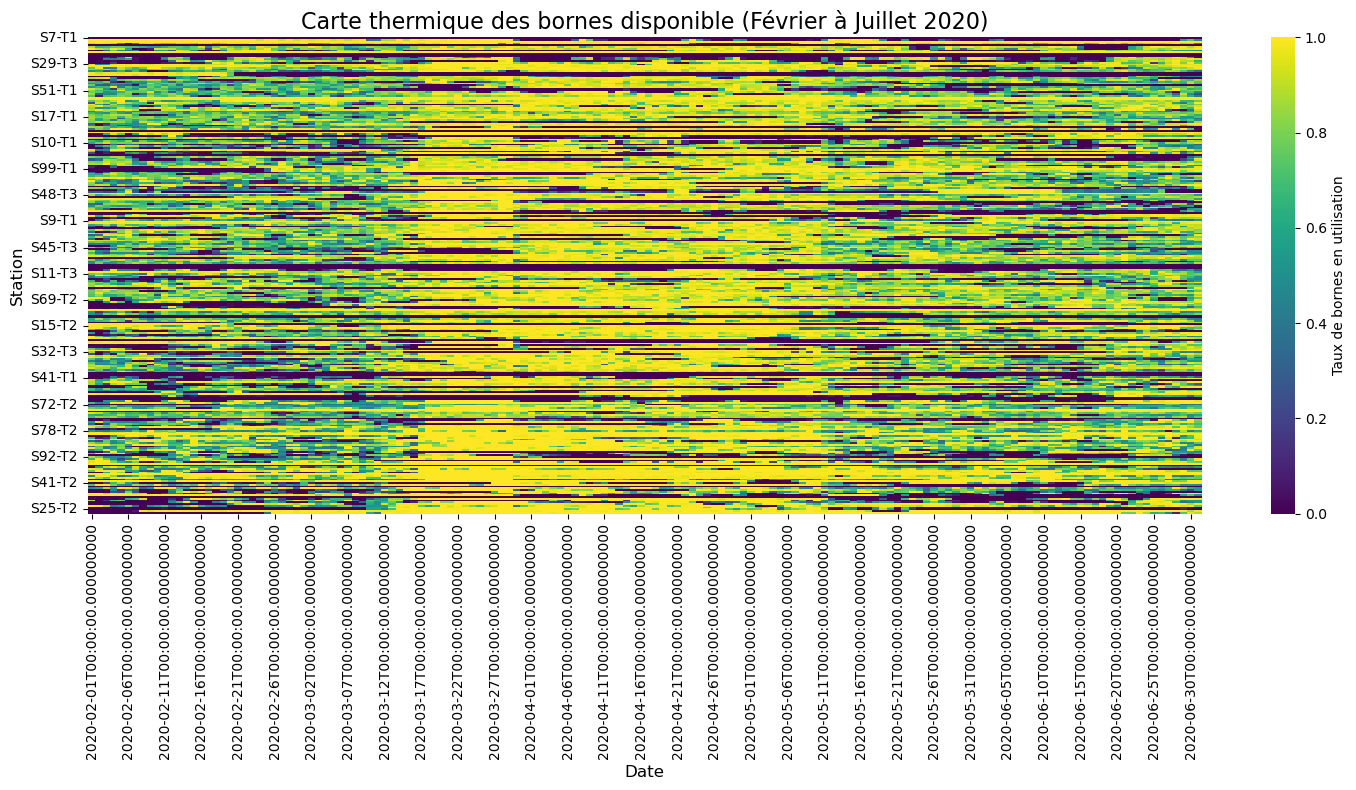

In [53]:
##Changements d'utilisation pendant la période de COVID-19

df_real_time['timestamp'] = pd.to_datetime(df_real_time['timestamp'], errors='coerce')
df_real_time.set_index('timestamp', inplace=True)

# Remplacement des statuts par des valeurs numériques (on laisse les NaN tel quel)
status_data = df_real_time.replace({'Down': 1, 'Offline': 0, 'Available': -1, 'Charging': 2, 'Passive': 3})

# Agrégation par jour
daily_charging = status_data.resample('D').apply(lambda x: (x == 2).mean())
daily_available= status_data.resample('D').apply(lambda x: (x == -1).mean())


# Filtrer les données pour la période étudiée
period_charging = daily_charging.loc["2020-02-01":"2020-07-01"]
period_available = daily_available.loc["2020-02-01":"2020-07-01"]

# Heatmap des bornes en utilisation de Février à Juillet 2020
plt.figure(figsize=(15, 8))
sns.heatmap(period_charging.T, cmap="viridis", cbar_kws={'label': 'Taux de bornes en utilisation'},
            xticklabels=5, yticklabels=15)
plt.title('Carte thermique des bornes en utilisation (Février à Juillet 2020)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Station', fontsize=12)
plt.tight_layout()
plt.show()

# Création du heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(period_available.T, cmap="viridis", cbar_kws={'label': 'Taux de bornes en utilisation'},
            xticklabels=5, yticklabels=15)
plt.title('Carte thermique des bornes disponible (Février à Juillet 2020)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Station', fontsize=12)
plt.tight_layout()
plt.show()

df_real_time.reset_index(inplace=True) #pour réaliser les heatmap, le timestamp avait été mis comme indice du dataframe, on remet l'indice par défaut
